In [146]:
#This class store the internsity and pitch 
class Pause_Info:
  def __init__(self,intensity,stinten,pitch,stpit,minsound,maxsound,performance,id,jokeName):
    self.intensity = intensity
    self.stinten= stinten
    self.pitch = pitch
    self.stpit= stpit
    self.minsound=minsound
    self.maxsound=maxsound
    self.performance=performance
    self.id=id
    self.jokeName=jokeName
    
    
def getJokeNameForEachPerformance(folderPath):
    os.chdir(folderPath)
    
    jokeNameDict={}
    
    for file in glob.glob("*.txt"):
        idDict={}
        filepath=folderPath+'\\'+file
        f = open(filepath, "r")
        key=f.readline()
        key=key.replace("\x00","")
        key=key.replace("\n","")
#         print(key)
        content=f.read();
        f.close()
        content=content.replace("\x00","")
        content=content.replace("\n\n","\n")
        if not content:
            continue
        lines=content.split('\n')
        lines.pop(0)
        lines.pop(-1)
        for line in lines:
            jokename=line.split(':')[0]
            id=int(line.split(':')[1].split('.')[0].split('_')[1])
#             print(jokename,id)
            idDict[id]=jokename
        jokeNameDict[key]=idDict
    
    return jokeNameDict
            

#This function extract intensity and pitch info from txt file and put all info in to a dictionary
def readTxT(path):
    f = open(path, "r")
    line = f.readline()
    
    #store the joke title
    Title = line.split('\\')[-2]
    Title=Title.replace("\x00","")
    joke_dict = {}

    content=f.read();
    f.close()
    
    #replace all these werid \x00 in python
    #also replace all the extra newline char
    content=content.replace("\x00","")
    content=content.replace("\n\n","\n")
    lines=content.split('\n')
    
    #remove the first and last extra new line char
    lines.pop(0)
    lines.pop(-1)

    count=0
    intensity=0
    stinten=0
    pitch=0
    stpit=0
    minsound=0
    maxsound=0
    
    #store 7 info of each audio
    for line in lines:
        if(count%7==0):
            name=line.split('.')[0]
            name=name.split('_')[-1]
            id=int(name)
        elif(count%7==1):
            intensity=round(float(line))
        elif(count%7==2):
            stinten=round(float(line))
        elif(count%7==3):
            pitch=round(float(line))
        elif(count%7==4):
            stpit=round(float(line))
        elif(count%7==5):
            minsound=round(float(line))
        else:
            maxsound=round(float(line))
            if(Title not in jokeNameDict):
                break
            idDict=jokeNameDict[Title]
            jokeName=idDict[id]
            #print(jokeName)
            joke_dict[jokeName]=Pause_Info(intensity,stinten,pitch,stpit,minsound,maxsound,Title,id,jokeName)
           # print(Title,id)
        count+=1
    return joke_dict


import glob, os



#in combine_joke_dict,
#key of combine_joke_dict represent the joke id
#value of combine_joke_dict is an array of 'Pause_Info' who are the same joke but in different perofrmance
#len of value represent how many different perofrmance contain this joke 
def findAlltxtAndCombine(folderPath):
    os.chdir(folderPath)
    combine_joke_dict={}
    
    #find all txt file inside folder
    for file in glob.glob("*.txt"):
        filepath=folderPath+'\\'+file
        single_joke_dict=readTxT(filepath)   
        for x in single_joke_dict:
            y=single_joke_dict[x]
            if x in combine_joke_dict:
                combine_joke_dict[x].append(y)
            else:
                combine_joke_dict[x]=[y]
    return combine_joke_dict         

78
robot_name_joke_2.ogg.wav


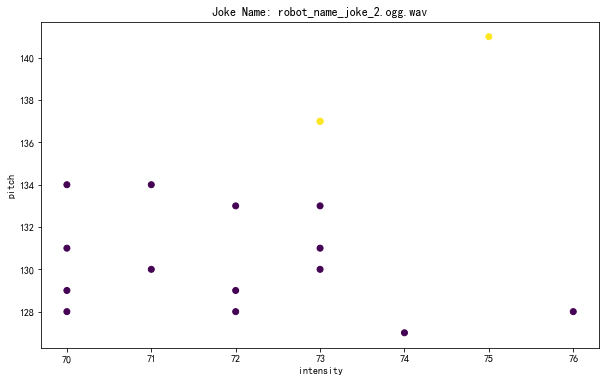

gdpr_joke.ogg.wav


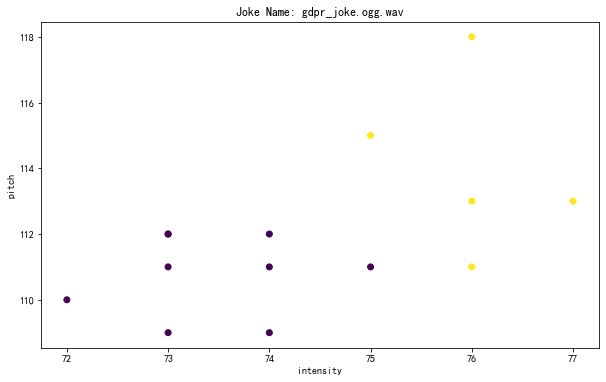

tags-inverse_kinematics_equations_positive_2.ogg.wav


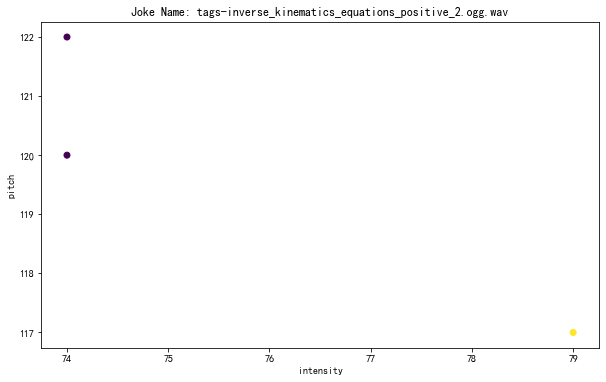

family_joke.ogg.wav


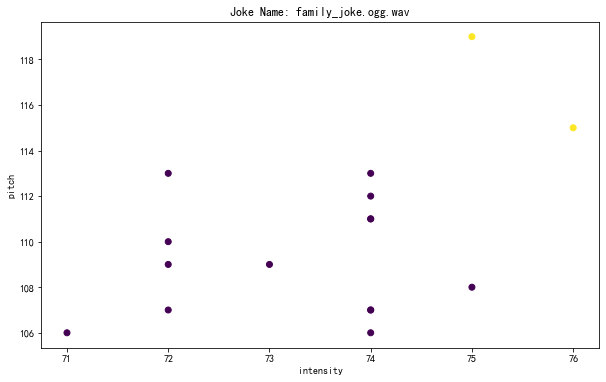

tags-family_joke_positive_2.ogg.wav


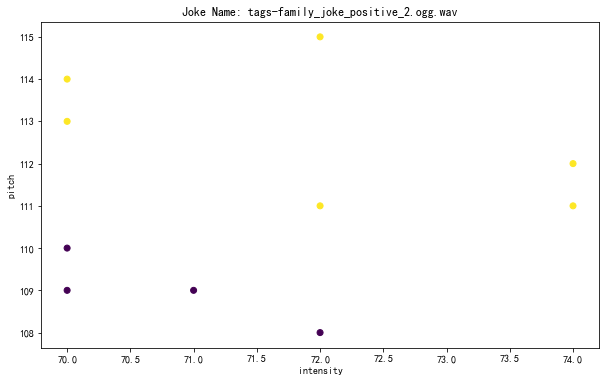

too_robotic_joke.ogg.wav


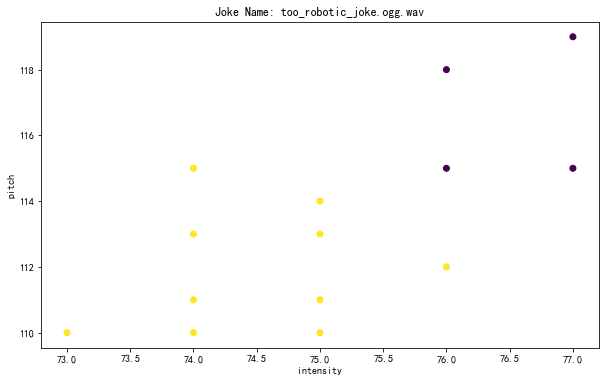

c3po_joke.ogg.wav


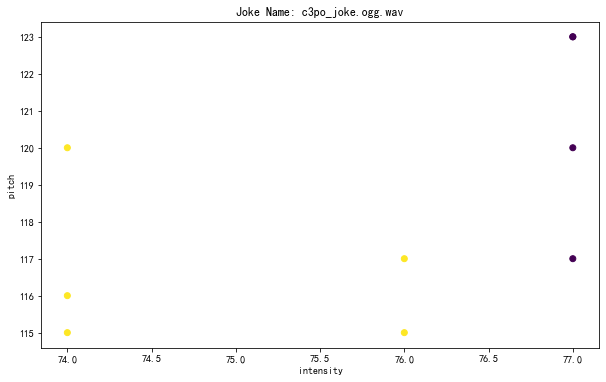

rosie_joke.ogg.wav


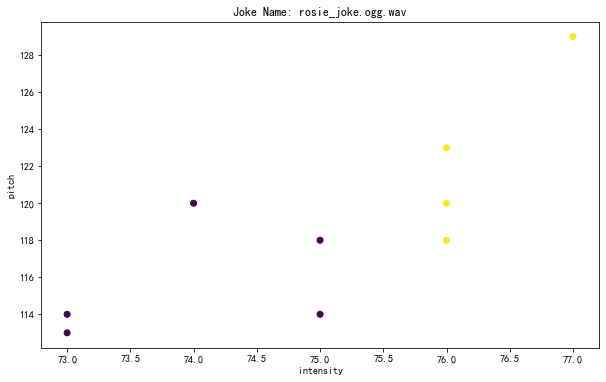

wall-e_joke.ogg.wav


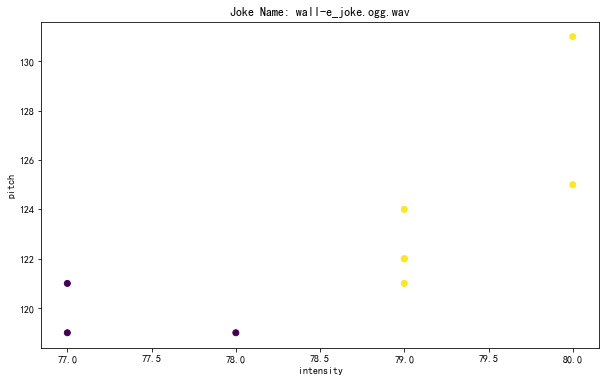

plastic_surgery_joke.ogg.wav


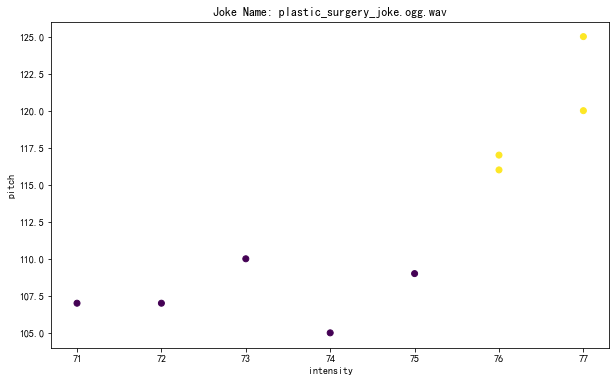

tags-plastic_surgery_joke_negative.ogg.wav


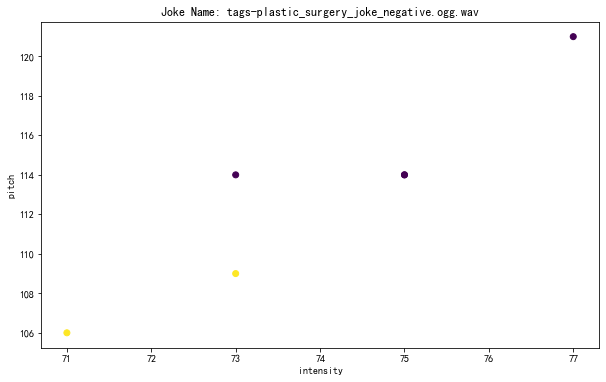

tags-gdpr_joke_positive.ogg.wav


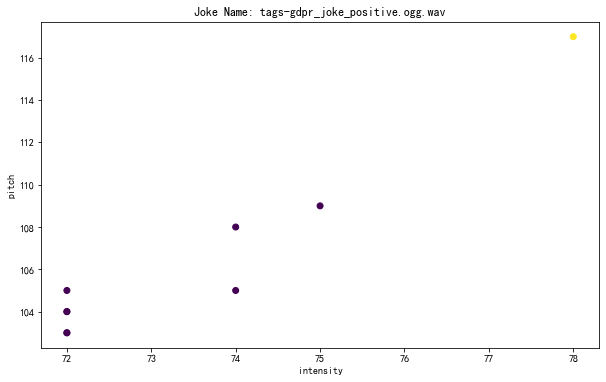

bender_joke.ogg.wav


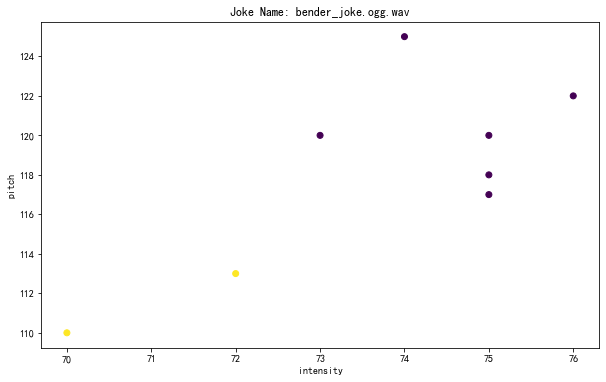

for_all_my_robots_joke.ogg.wav


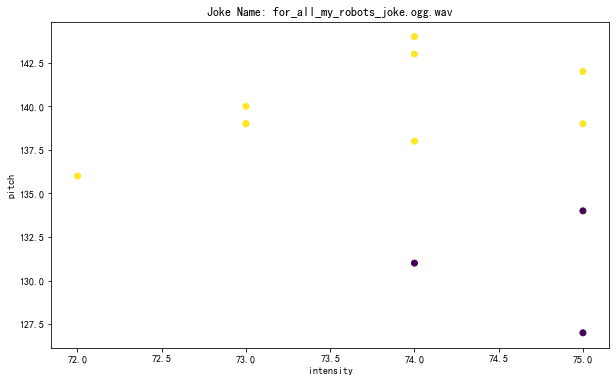

tags-robot_joke_positive.wav


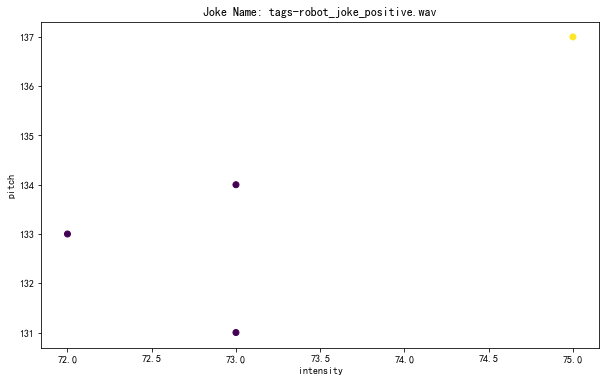

white_people_joke.ogg.wav


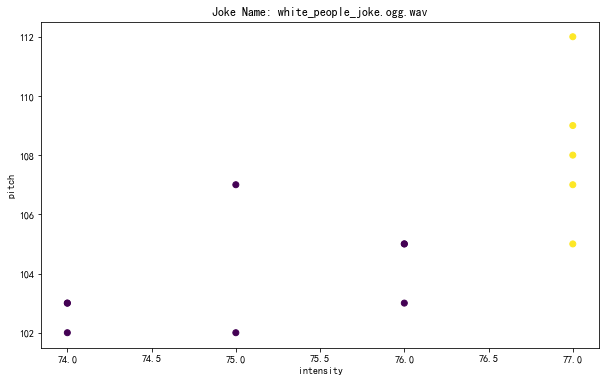

terminator_joke.ogg.wav


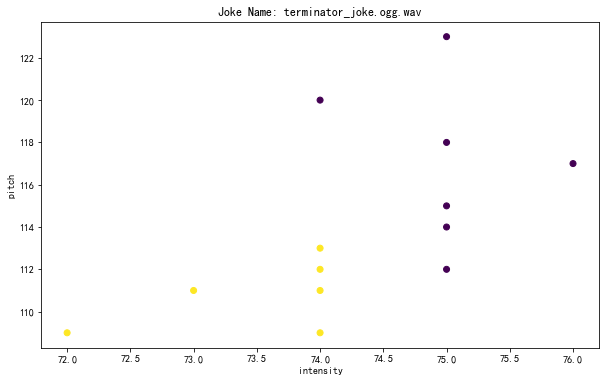

tags-white_people_joke_positive_2.ogg.wav


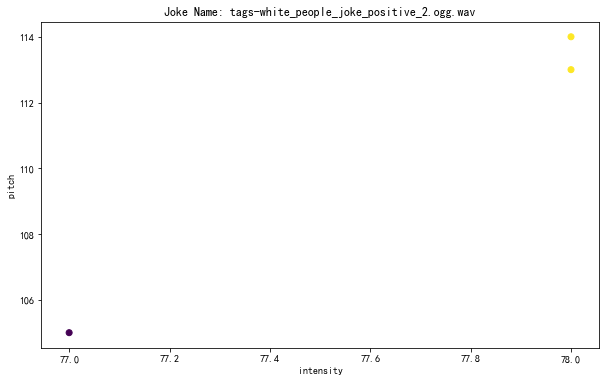

baha_men_joke_oregon.ogg.wav


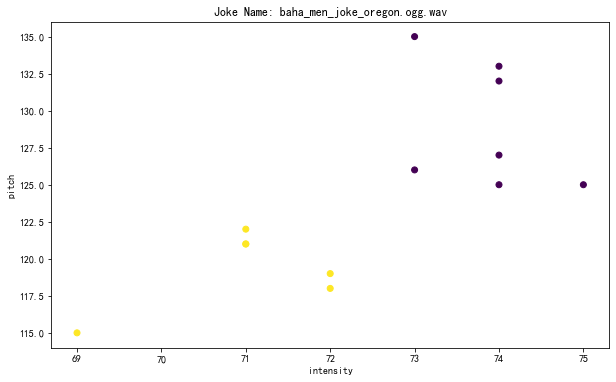

light_bulb_joke.ogg.wav


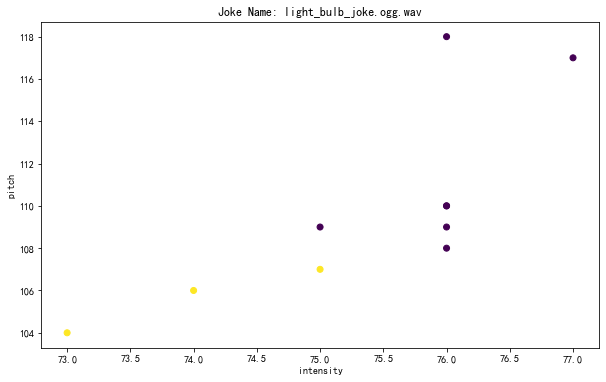

robot_tinder_2.ogg.wav


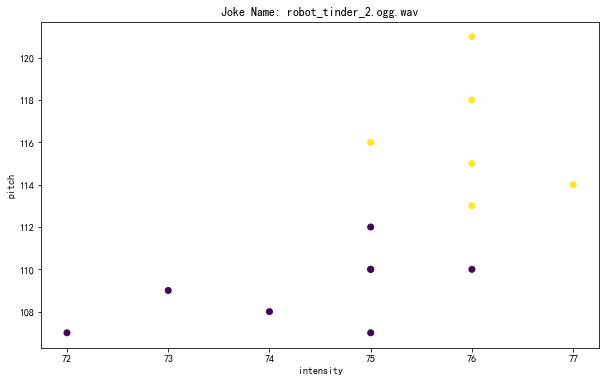

tags-robot_tinder_2_negative.ogg.wav


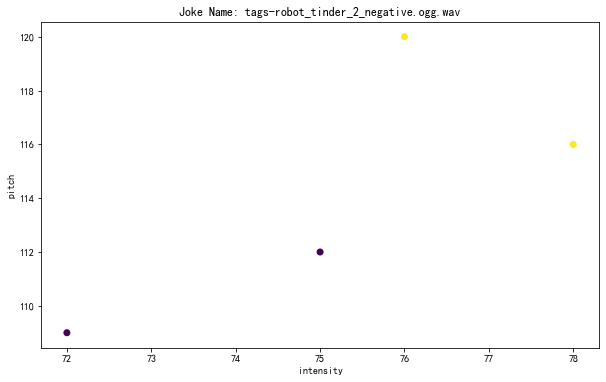

siri_backpropagate.ogg.wav


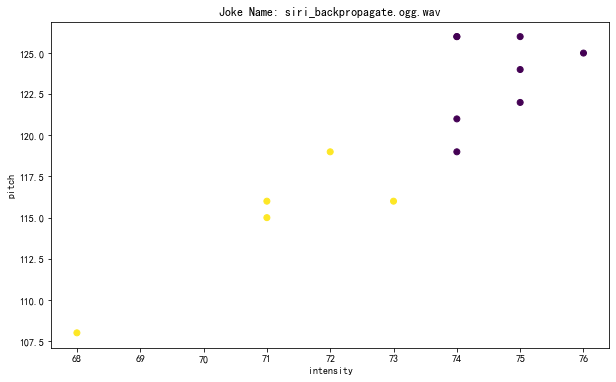

big_chips_joke.ogg.wav


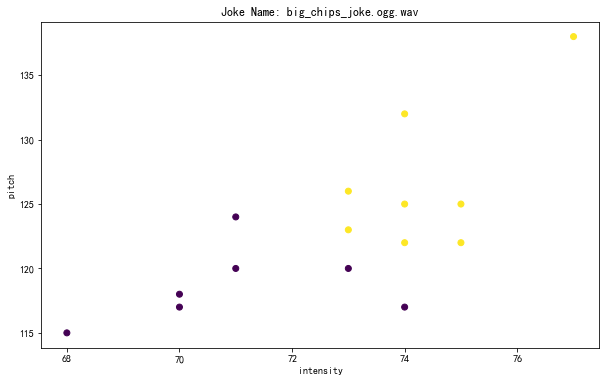

catfish_joke_2.ogg.wav


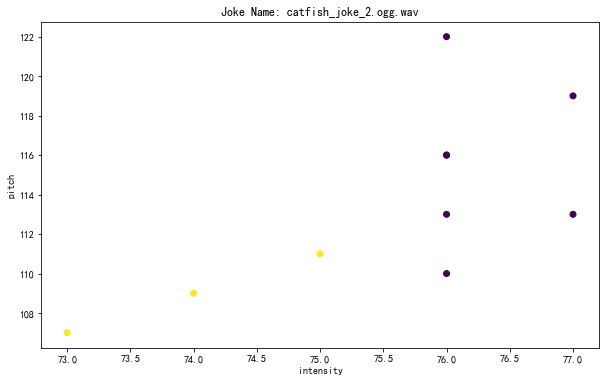

tags-catfish_joke_positive.ogg.wav


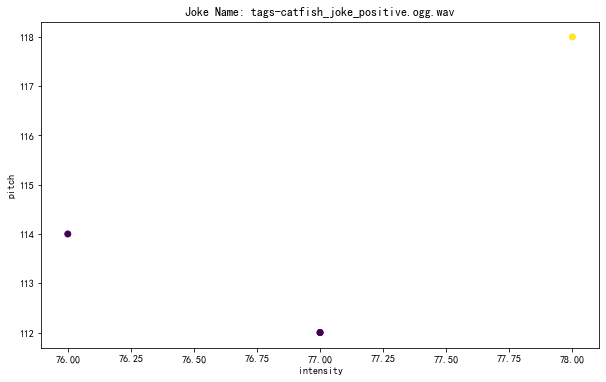

ip_address_joke_2.ogg.wav


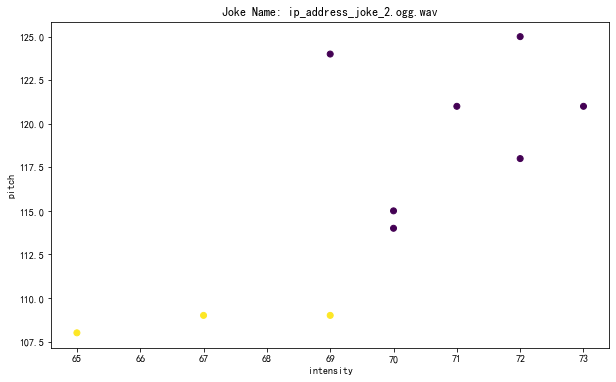

encryption_joke.ogg.wav


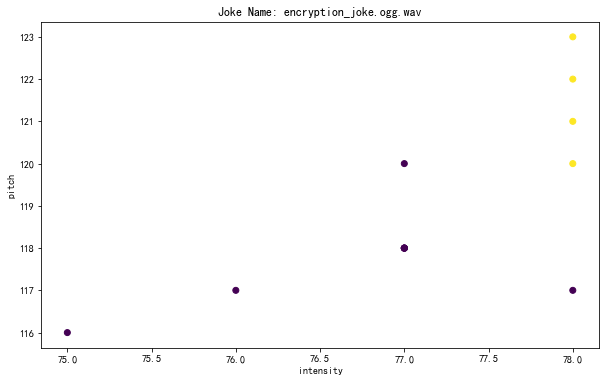

tags-encryption_joke_positive_2.ogg.wav


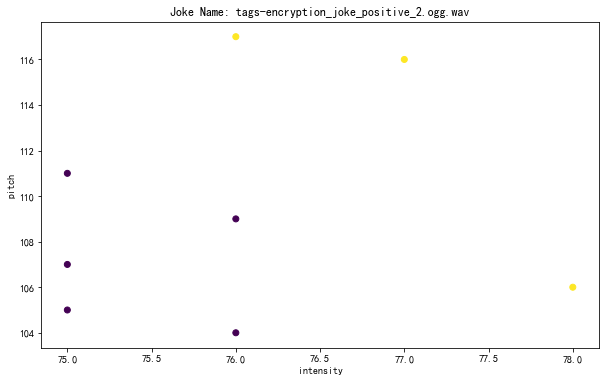

robot_sexy_times.ogg.wav


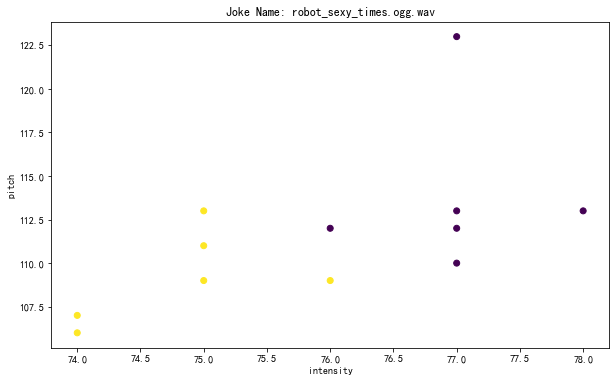

closing_take_jobs.ogg.wav


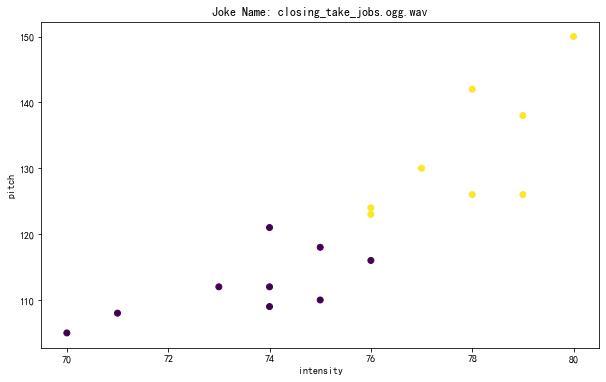

silicon_valley_joke_pt1.wav


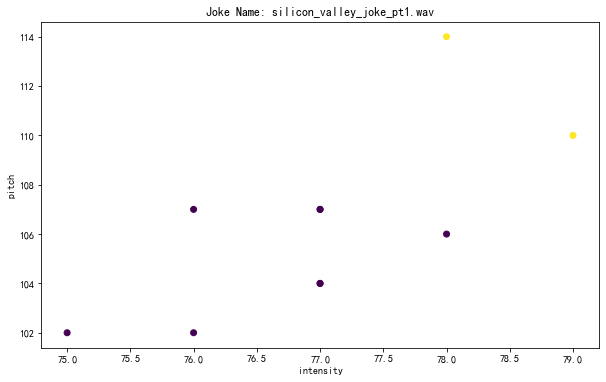

silicon_valley_joke_pt2.wav


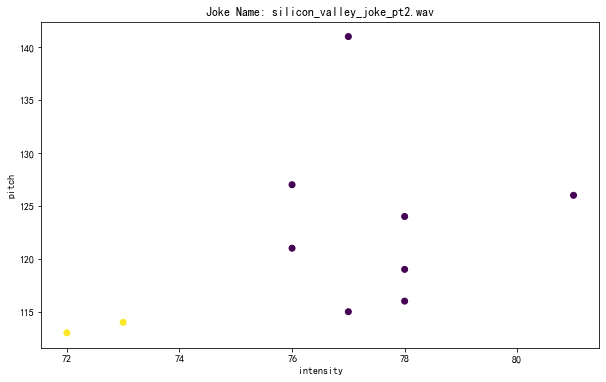

rent_prices_oregon.ogg.wav


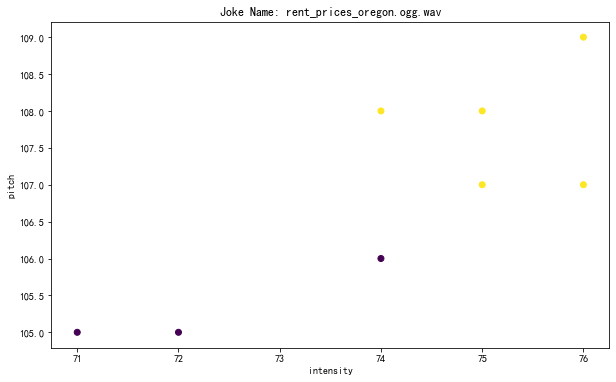

tags-rent_prices_oregon_negative.ogg.wav


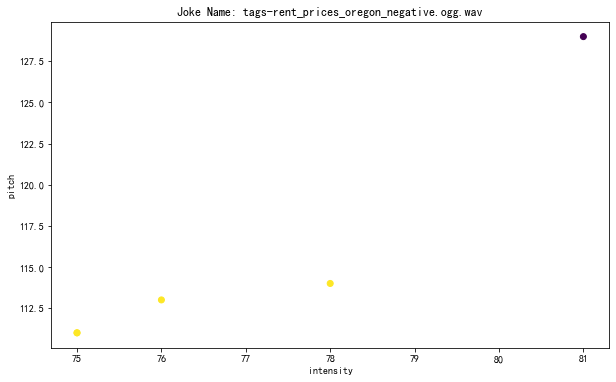

job_joke.ogg.wav


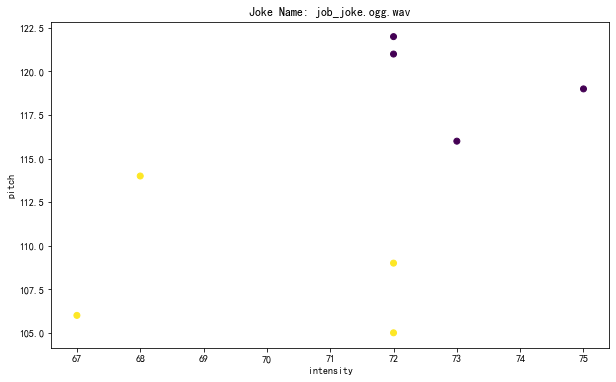

inverse_kinematics_equations.ogg.wav


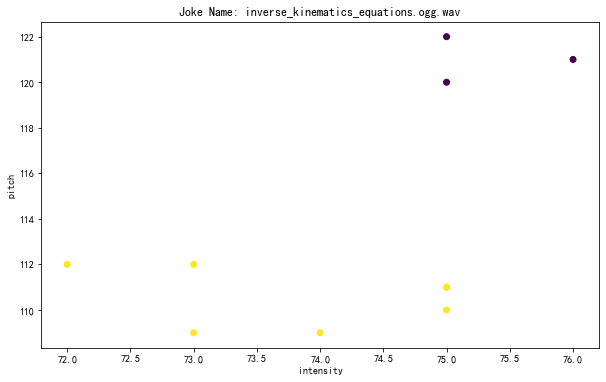

robot_babies.ogg.wav


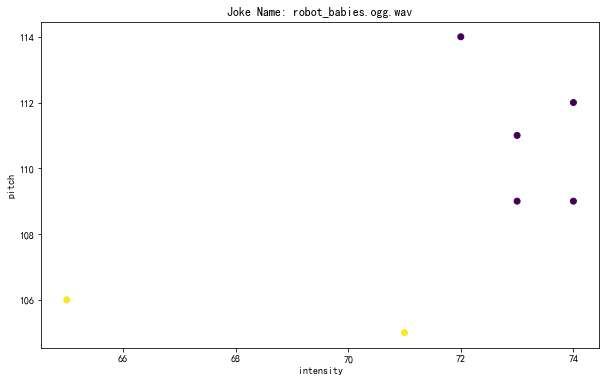

boogie.ogg.wav


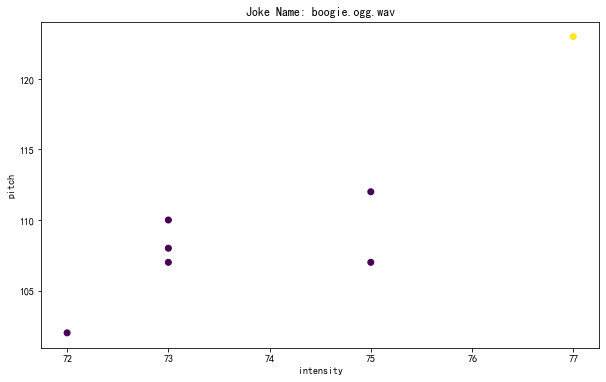

tags-robot_joke_negative_2.ogg.wav


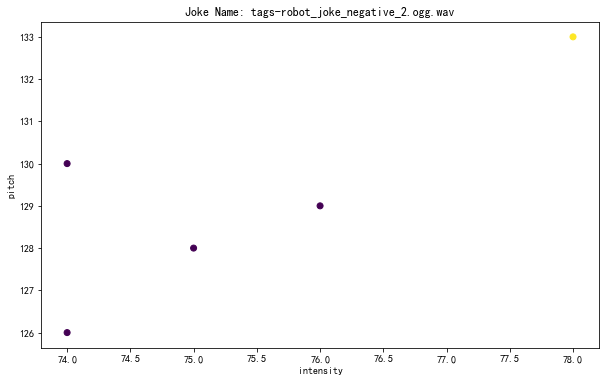

selfie_drone.ogg.wav


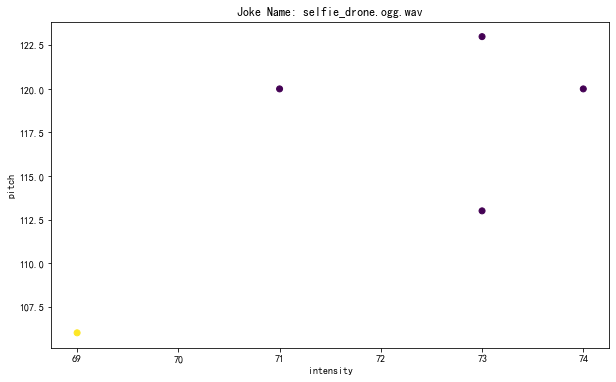

vibrator.ogg.wav


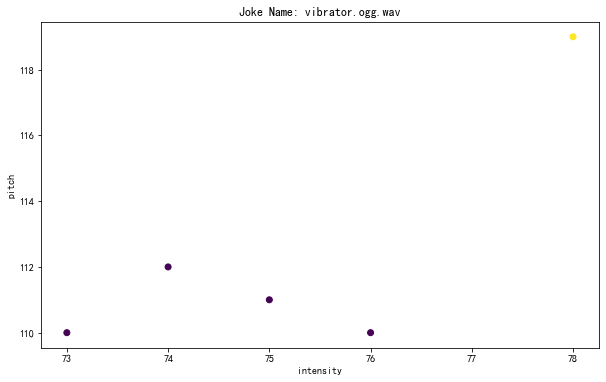

vibrator_pt_2.ogg.wav


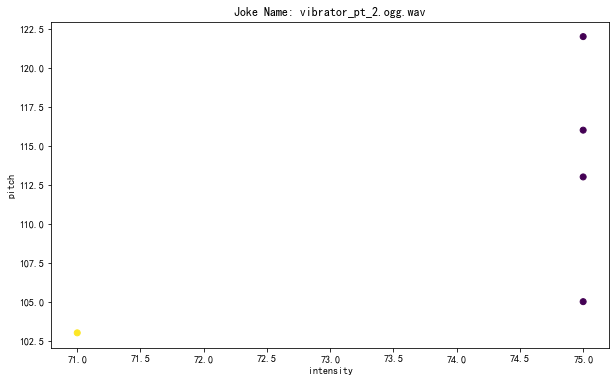

congratulations_youve_won_joke.wav


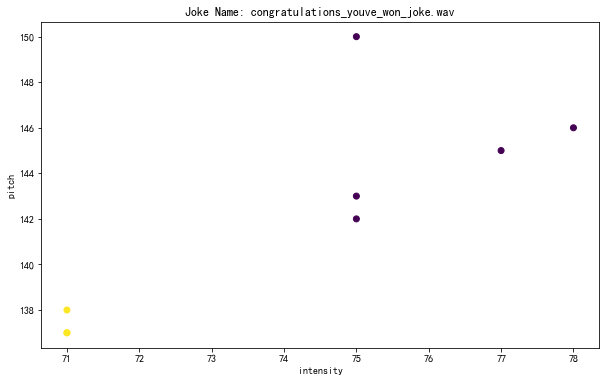

congratulations_im_feeling_lucky.wav


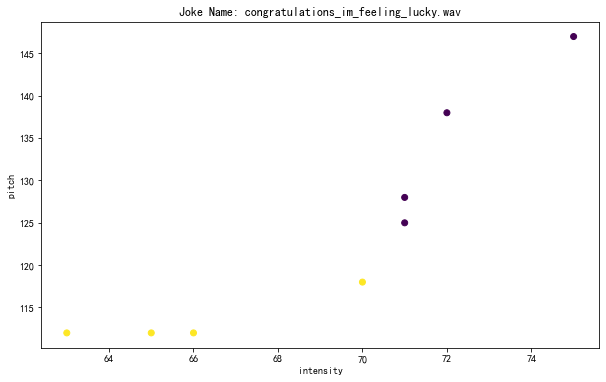

megaman.ogg.wav


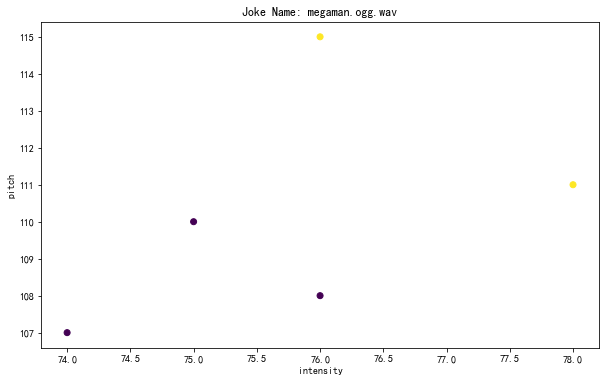

smoking_joke.ogg.wav


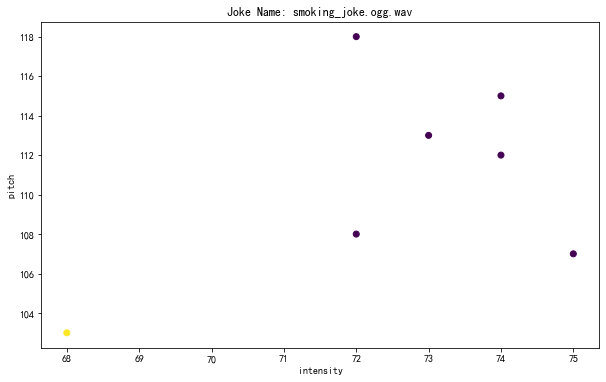

stripper_joke.ogg.wav


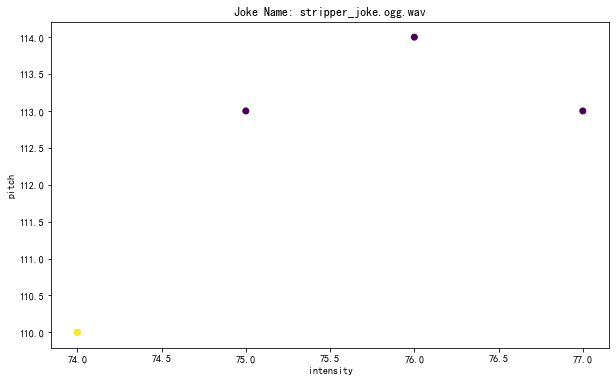

stripper_vagina_joke.ogg.wav


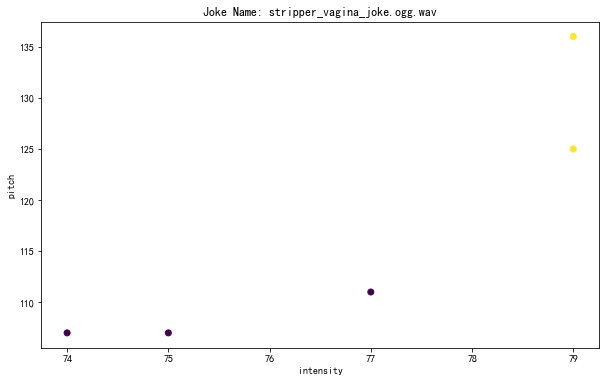

self_driving_limo.ogg.wav


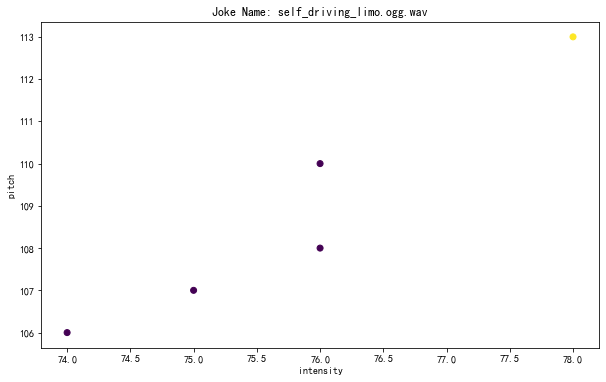

tags-self_driving_limo_positive.ogg.wav


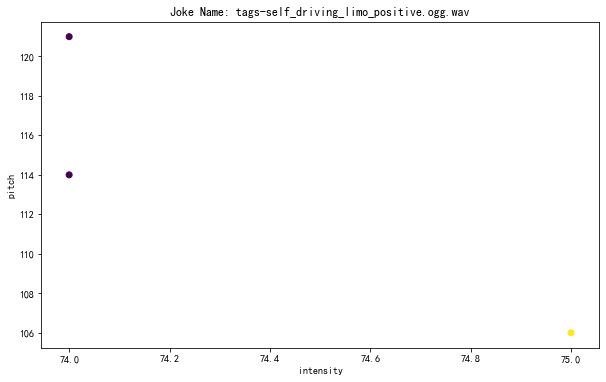

software_update.ogg.wav


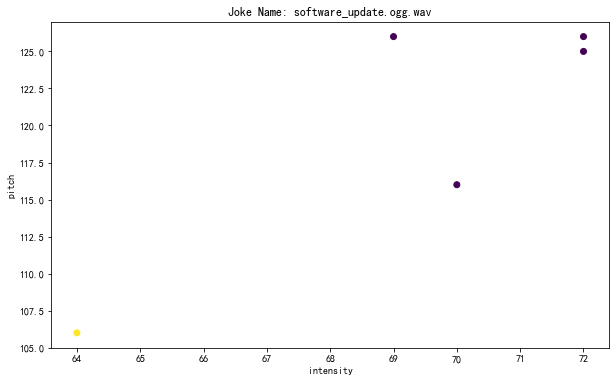

power_cord_joke.wav


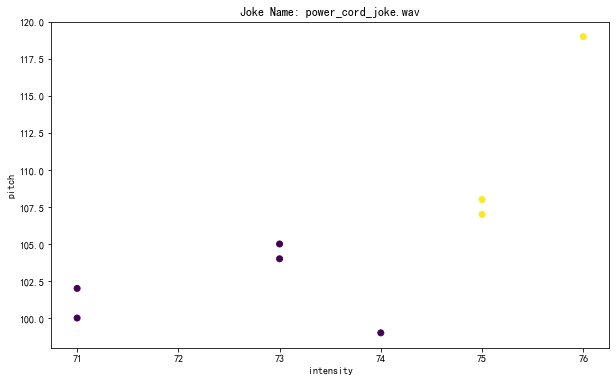

tags-power_cord_joke_negative.wav


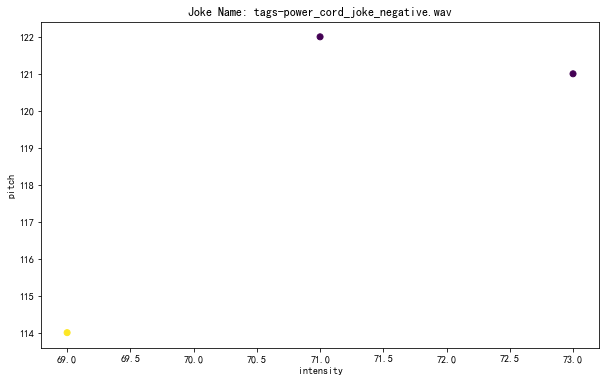

domain_name_joke.wav


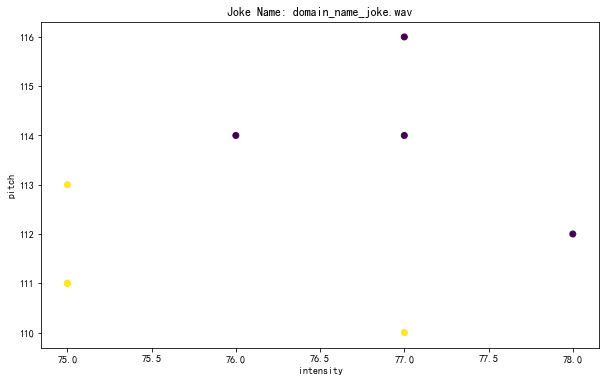

tags-megaman_positive.ogg.wav


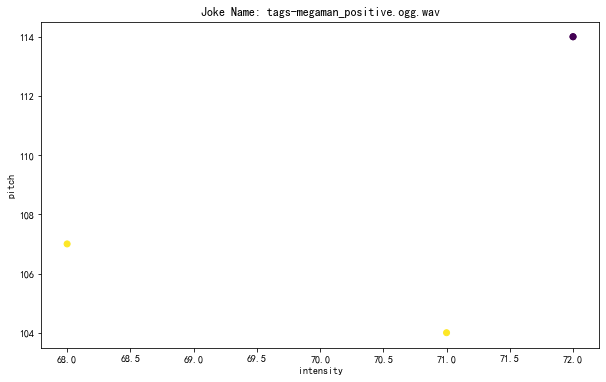

domain_name_dot_com.wav


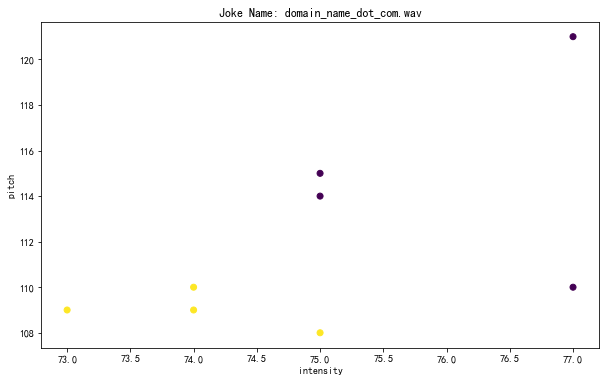

robot_drugs.ogg.wav


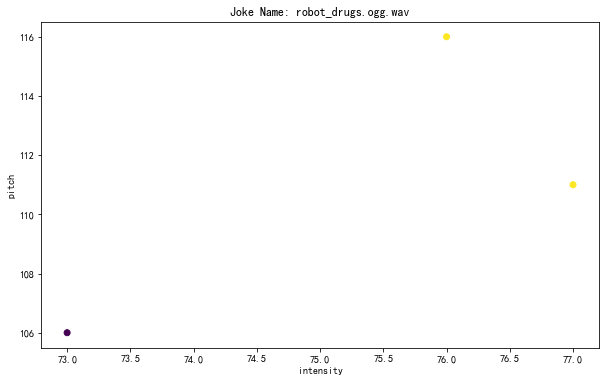

tags-white_people_joke_negative.ogg.wav


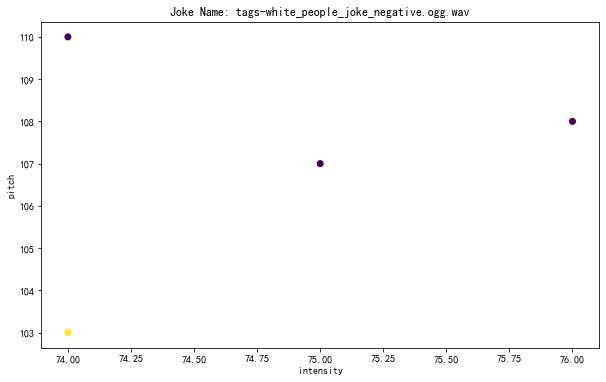

tags-robot_tinder_2_positive.ogg.wav


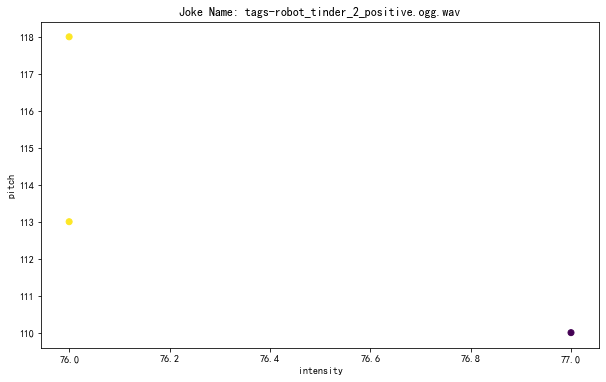

tags-software_update_positive.ogg.wav


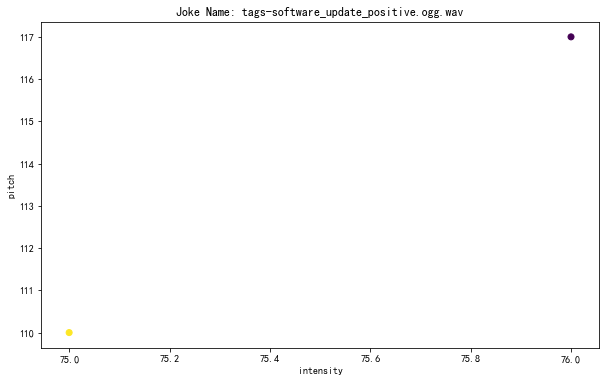

tags-robot_babies_positive.ogg.wav


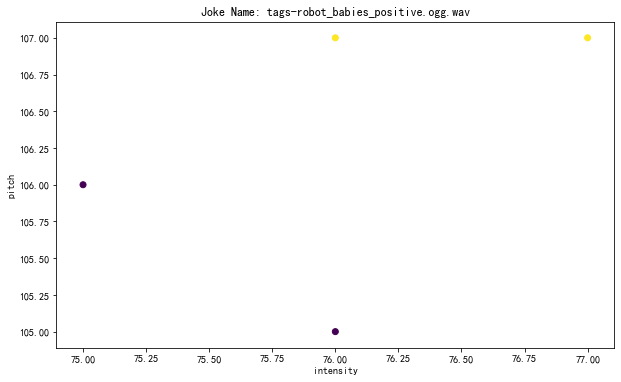

tags-too_robotic_joke_negative.wav


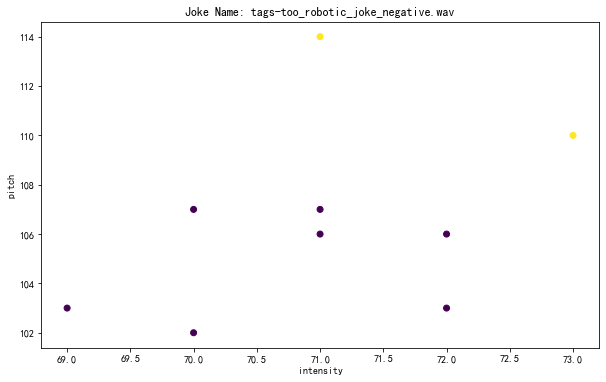

tags-self_driving_limo_negative.ogg.wav


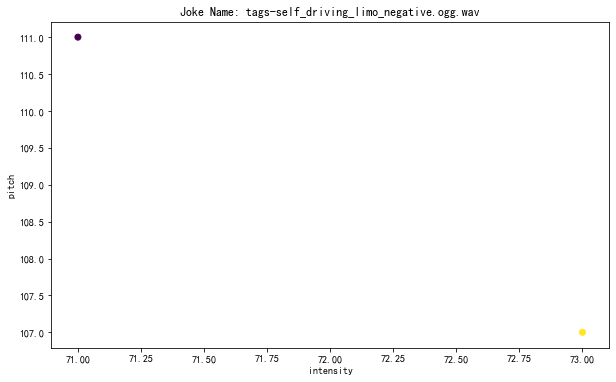

tags-metal_ceiling_positive.ogg.wav


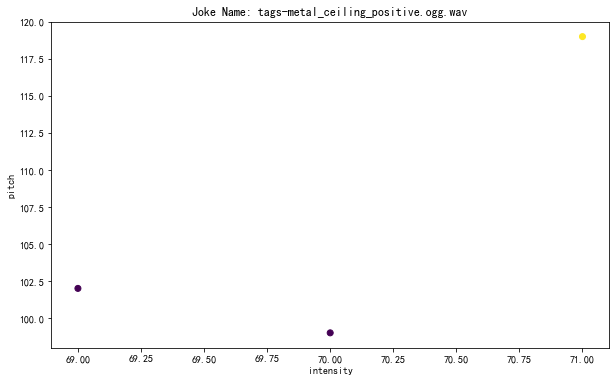

tags-inverse_kinematics_equations_negative.ogg.wav


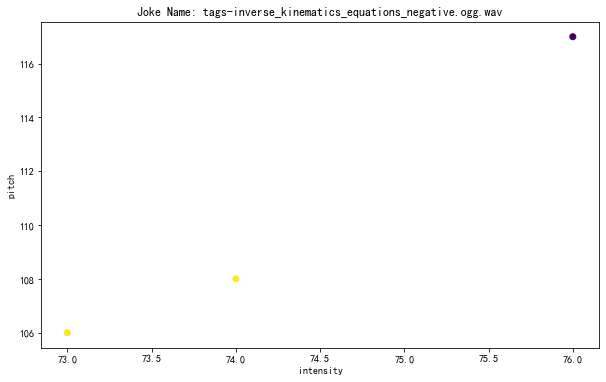

In [147]:
%matplotlib inline

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import scale
from numpy import random, float
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

#info_arr represent an array of same joke in different performances
#choice=1 is using intensity and pitch as x-y axis
#choice=2 is using std intensity and std pitch as x-y axis
def clusterData(Info_arr,choice):
    jokeid=Info_arr[0].jokeName.replace('/','-')
    data=[]
    x=[]
    y=[]
    performanceName=[]
    Xname,Yname='',''
    if(choice==1):
        for joke in Info_arr:
            X=joke.intensity
            Y=joke.pitch
            data.append((X,Y))
            performanceName.append(joke.performance)
            x.append(X)
            y.append(Y)
            Xname="intensity"
            Yname="pitch"
    elif(choice==2):
        for joke in Info_arr:
            X=joke.stinten
            Y=joke.stpit
            data.append((X,Y))
            performanceName.append(joke.performance)
            x.append(X)
            y.append(Y)
            Xname="standard deviation intensity"
            Yname="standard deviation pitch"
    
    if(len(data)<2):
        txtName="../jokeoutput/joke"+str(jokeid)+".txt"
        if os.path.isfile(txtName):
            os.remove(txtName) 
        f = open(txtName, "a")
        f.write("There is only 1 data in this dataset")
        f.close()
        return 
        
    # spilt them into 2 group
        
    model = KMeans(n_clusters=2)

    # Note I'm scaling the data to normalize it! Important for good results.
    model = model.fit(scale(data))

    # We can look at the clusters each data point was assigned to

    
    count=0
    Group0=[]
    Group1=[]
    for i in data:
        #print("performance Name: "+str(performanceName[count])+"\t","Data values: "+str(i)+"\t","Group ID: "+str(model.labels_[count]))  
        if(model.labels_[count]==0):
            Group0.append((performanceName[count],str(i)))
        else:
            Group1.append((performanceName[count],str(i)))
        count+=1

    Group0txt="Group0\n"
    Group1txt="Group1\n"
    for a in Group0:
        Group0txt=Group0txt+"performance Name: "+str(a[0])+"  "+"Data values: "+str(a[1])+"\n"
        
    for a in Group1:
        Group1txt=Group1txt+"performance Name: "+str(a[0])+"  "+"Data values: "+str(a[1])+"\n"

    
    p=os.getcwd()
    
    
    #save all info into txt
    print(jokeid)
    txtName="../jokeoutput/"+str(jokeid)+".txt"

    if os.path.isfile(txtName):
        os.remove(txtName) 
    f = open(txtName, "a")
    f.write(Group0txt+Group1txt)
    f.close()
    
    
    plt.figure(figsize=(10,6))
    plt.scatter(x, y, c=model.labels_.astype(float))
    plt.title("Joke Name: "+str(jokeid))
    plt.xlabel(Xname)
    plt.ylabel(Yname)
    
    pngName="../jokeoutput/"+str(jokeid)+".png"
    
    #remove the existing png file
    if os.path.isfile(pngName):
        os.remove(pngName) 
    
    #save as png file
    plt.savefig(pngName)
    plt.show()
    
def main():
    
    global jokeNameDict
    jokeNameDict=getJokeNameForEachPerformance(r"E:\CapstoneWork\k-means-test_by_Tony\joke_name_matching")
    #i am using directory pitch_inten_avg_std_minmax since it is the test contain most information
    combine_joke_dict=findAlltxtAndCombine(r"E:\CapstoneWork\k-means-test_by_Tony\jokeinput")
    print(len(combine_joke_dict))
    for x in combine_joke_dict:
        clusterData(combine_joke_dict[x],1)
        
main()